In [7]:
from netCDF4 import Dataset
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math

The Obukhov length is computed as follows:

$$
L=-\frac{u_*^3}{k\left(\frac{g}{\Theta_{v_0}}\right)\left(\frac{\overline{w^\prime\Theta_v^\prime}}{c_p\rho}\right)}
$$

where $u_*$ is the friction velocity, $k$ the von Karman constant (approximately 0.4), $\Theta_v$ the potential temperature at (height?) $v$, $w^\prime$ the vertical variation in wind velocity, $\rho$ the density of the air, $c_p$ the specific heat, $g$ the gravitational constant. Note that $\overline{w^\prime\Theta_v^\prime}$ is the turbulent kinematic heat flux, aka sensible heat flux. The specific heat is a function of temperature, but between 250 and 350 K it takes values between 1.003 and 1.008 kJ/kg.K, thus we can assume it constant at 1.005. The air density can be derived using the ideal gas law:

$$
\rho=\frac{P}{RT}
$$

with $P$ the surface pressure in Pascal, $T$ the surace temperature in Kelvin, and $R$ the specific gas constant. For dry air, $R=287.058$ J/kg.K, and varies slightly depending on the composition of air (e.g. moisture) TODO does it matter?

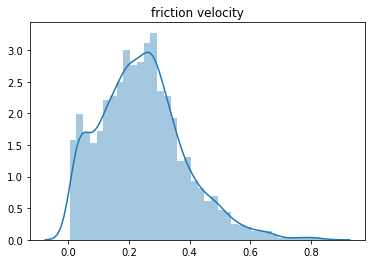

In [8]:
sns.distplot(fluxds['UST'][:])
plt.title('friction velocity')
plt.show()

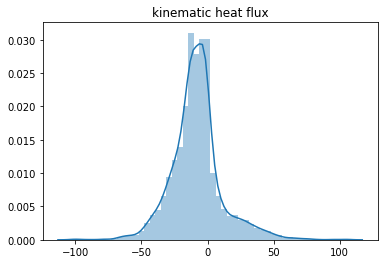

In [9]:
sns.distplot(fluxds['H'][:])
plt.title('kinematic heat flux')
plt.show()

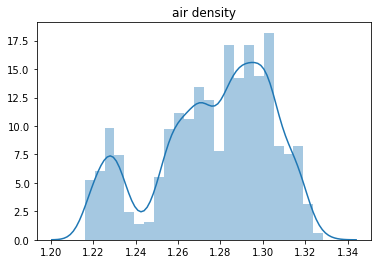

In [10]:
air_density = 100 * meteods['P0'][:] / (287.058 * (273.15 + meteods['TA002'][:]))

sns.distplot(air_density)
plt.title('air density')
plt.show()

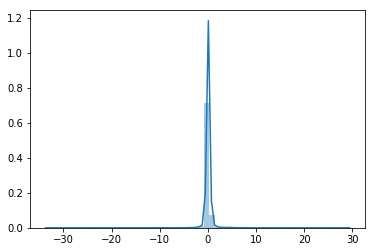

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
L,4032.0,0.08145,1.434129,-32.903099,-1.754847,-0.293967,0.001644,0.052662,0.138596,0.654895,2.528965,28.649832


In [11]:
L = -fluxds['UST'][:]**3 / (
    0.4 * 
    (9.81 / (273.15 + meteods['TA002'][:])) *
    (fluxds['H'][:] / (1.005 * air_density))
)

sns.distplot(L)
plt.show()
pd.DataFrame([L], index=['L']).T.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T

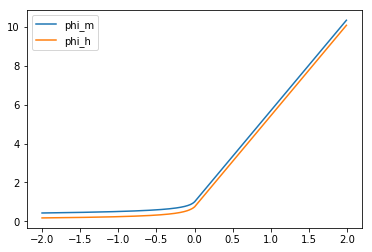

In [12]:
def phi_m(zL):
    if zL < 0:
        return math.pow(1 - 15 * zL, -0.25)
    else:
        return 1 + 4.7 * zL

    
def phi_h(zL):
    if zL < 0:
        return 0.74 * math.pow(1 - 9 * zL, -0.5)
    else:
        return 0.74 + 4.7 * zL


xx = np.arange(-2, 2, 0.01)
ym = list(map(phi_m, xx))
yh = list(map(phi_h, xx))
plt.plot(xx, ym, label='phi_m')
plt.plot(xx, yh, label='phi_h')
plt.legend()
plt.show()

wind and temperature profile

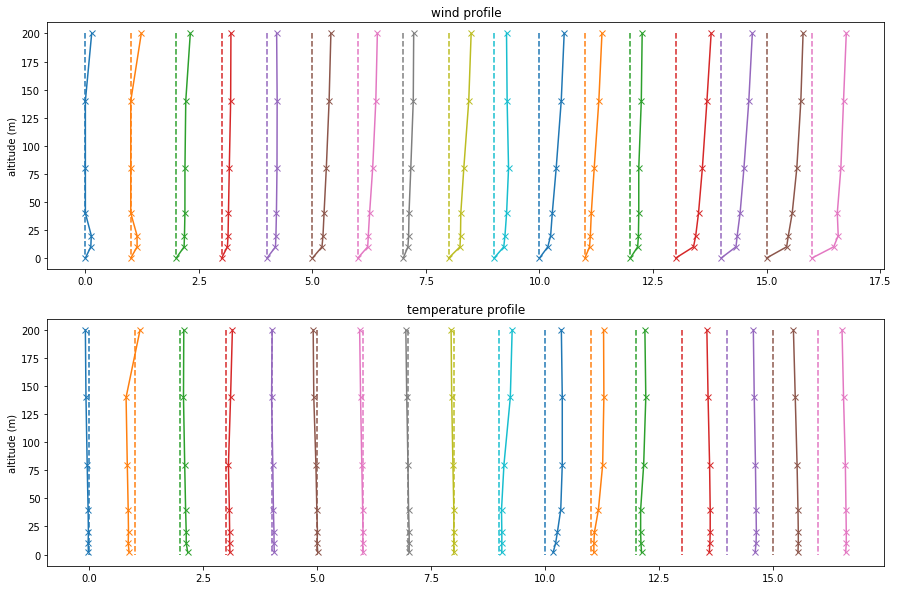

In [33]:
plt.figure(figsize=(15, 5))


fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(15, 10)

ax1.set_title('wind profile')
ax1.set_ylabel('altitude (m)')

ax2.set_title('temperature profile')
ax2.set_ylabel('altitude (m)')

for i, tt in enumerate(towmetds['time'][::250]):
    ws = towmetds['F'][tt][:-1]
    qq = ax1.plot([i + w / 20 for w in ws] + [i], list(towmetds['z'][:-1]) + [0], 'x-')
    ax1.plot([i, i], [200, 0], '--', c=qq[0]._color)
    
    ts = towmetds['TA'][tt]
    qq = ax2.plot([i + (t - 273.15) / 15 for t in ts], towmetds['z'][:], 'x-')
    ax2.plot([i, i], [200, 0], '--', c=qq[0]._color)

plt.show()

wind/temperature profile gradient

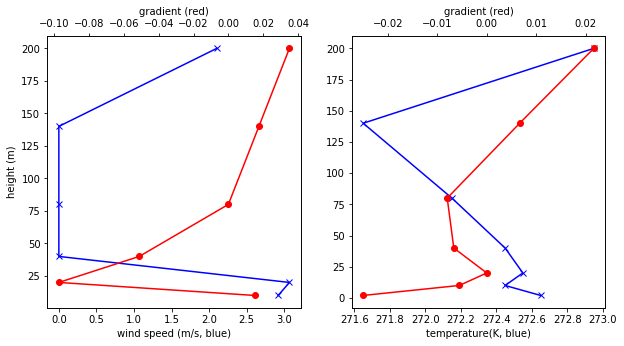

In [22]:
def get_derivative(xs, ys):
    dxdy = []
    for i in range(len(xs)):
        if i == 0:
            d = (ys[i] - ys[i + 1]) / (xs[i] - xs[i + 1])
        elif i == len(xs) - 1:
            d = (ys[i - 1] - ys[i]) / (xs[i - 1] - xs[i])
        else:
            d = (ys[i - 1] - ys[i + 1]) / (xs[i - 1] - xs[i + 1])

        dxdy.append(d)
    
    return dxdy


tt = towmetds['time'][14]

ws = towmetds['F'][tt][:-1]
hw = towmetds['z'][:-1]

ts = towmetds['TA'][tt]
ht = towmetds['z'][:]

dwdz = get_derivative(hw, ws)
dtdz = get_derivative(ht, ts)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

ax1.set_ylabel('altitude (m)')
ax1.plot(ws, hw, 'x-', c='b')
ax1.set_xlabel('wind speed (m/s, blue)')
ax12 = ax1.twiny()
ax12.plot(dwdz, hw, 'o-', c='r')
ax12.set_xlabel('gradient (red)')

ax2.plot(ts, ht, 'x-', c='b')
ax2.set_xlabel('temperature(K, blue)')
ax22 = ax2.twiny()
ax22.plot(dtdz, ht, 'o-', c='r')
ax22.set_xlabel('gradient (red)')

plt.show()

experimental wind shear is computed as

$$
\phi_m\left(\frac{z}{L}\right)=\frac{kz}{u_*}\frac{\partial \overline{U}}{\partial z}
$$

with $\overline{U}$ the average wind speed.

experimental temperature gradient is

$$
\phi_h\left(\frac{z}{L}\right)=
\frac{kz}{\theta_*}\frac{\partial\overline\Theta}{\partial z}=
-\frac{kzu_*c_p\rho}{\overline{w^\prime\Theta_{v_0}^\prime}}\frac{\partial\overline\Theta}{\partial z}
$$

with $\overline{w^\prime\Theta_{v_0}^\prime}$ being the turbulent surface kinematic heat flux and $\theta_*=-\overline{w^\prime\Theta_{v_0}^\prime}/(u_*c_p\rho)$

In [37]:
exp_z_L_m, exp_phi_m = [], []
exp_z_L_h, exp_phi_h = [], []

for i, tt in enumerate(towmetds['time']):
    # use temperature at 0.1m if available, fallback to temperature at 1.5/2m otherwise
    surf_temp = meteods['TA000'] if 'TA000' in meteods.variables else meteods['TA002']
    air_dens = 100 * meteods['P0'][tt] / (287.058 * (273.15 + surf_temp[tt]))
    lval = -fluxds['UST'][tt]**3 / (
        0.4 * 
        (9.81 / (273.15 + surf_temp[tt])) *
        (fluxds['H'][tt] / (1.005 * air_dens))
    )
    
    exp_z_L_m.append(towmetds['z'][-2] / lval)
    exp_z_L_h.append(towmetds['z'][-1] / lval)
    
    # compute only at lowest layer (10m)
    # because L and H are computed with surface measurements
    dwdz = get_derivative(towmetds['z'][:-1], towmetds['F'][tt][:-1])
    exp_phi_m.append(
        dwdz[-1] * 0.4 * towmetds['z'][-2] / fluxds['UST'][tt]
    )
    
    dtdz = get_derivative(towmetds['z'][:], towmetds['TA'][tt][:])
    exp_phi_h.append(
        -dtdz[-1] * 0.4 * towmetds['z'][-1] * fluxds['UST'][tt] * 1.005 * air_dens
        / fluxds['H'][tt]
    )

In [38]:
pd.DataFrame([exp_z_L_m, exp_phi_m, exp_z_L_h, exp_phi_h],
             index=['zL_m', 'phi_m', 'zL_h', 'phi_h']).T.describe(
    percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
).T

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
zL_m,4032.0,455.615517,3119.389061,-424.727718,-234.695953,-62.829512,23.652707,84.138164,139.805199,699.639887,13523.909162,51555.466758
phi_m,4032.0,0.910673,1.461779,-2.655209,-1.616408,-0.126985,0.450953,0.628343,0.862929,3.115766,8.877729,18.613522
zL_h,4032.0,91.123103,623.877812,-84.945544,-46.939191,-12.565902,4.730541,16.827633,27.961040,139.927977,2704.781832,10311.093352
phi_h,4032.0,0.000204,0.003157,-0.041154,-0.004265,-0.001447,-0.000276,0.000000,0.000515,0.002052,0.005428,0.047314


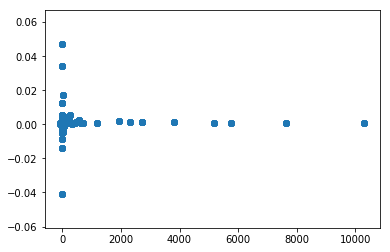

In [39]:
plt.scatter(exp_z_L_h, exp_phi_h)
plt.show()

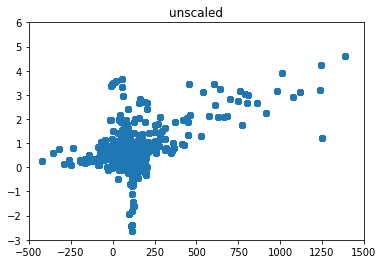

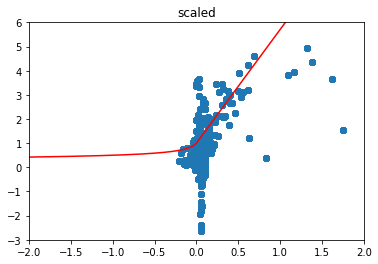

In [40]:
plt.scatter(exp_z_L_m, exp_phi_m)
plt.xlim(-500, 1500)
plt.ylim(-3, 6)
plt.title('unscaled')
plt.show()

plt.scatter([x / 2000 for x in exp_z_L_m], exp_phi_m)
plt.xlim(-2, 2)
plt.ylim(-3, 6)
xx = np.arange(-2, 2, 0.01)
plt.plot(xx, list(map(phi_m, xx)), 'r')
plt.title('scaled')
plt.show()

In [4]:
towmetds = Dataset('data/cesar_tower_meteo_lc1_t10_v1.0_200102.nc')
towmetds.variables

OrderedDict([('iso_dataset', <class 'netCDF4._netCDF4.Variable'>
              |S1 iso_dataset()
                  hierarchyLevel: dataset
                  url: http://www.cesar-database.nl
                  protocol: website
                  topic: climatologyMeteorologyAtmosphere
                  westbound_longitude: 4.926
                  eastbound_longitude: 4.926
                  southbound_latitude: 51.97
                  northbound_latitude: 51.97
                  datasetDateType: publication
                  code: 28992
                  codeSpace: EPSG
                  accessConstraints: CESAR data policy
                  useLimitation: None
                  organisationName_dataset: Royal Netherlands Meteorological Institute (KNMI)
                  email_dataset: fred.bosveld@knmi.nl
                  role_dataset: Principle Investigator
                  organisationName_metadata: Royal Netherlands Meteorological Institute (KNMI)
                  role_metadata: 

In [5]:
meteods = Dataset('data/cesar_surface_meteo_lc1_t10_v1.0_200102.nc')
meteods.variables

OrderedDict([('iso_dataset', <class 'netCDF4._netCDF4.Variable'>
              |S1 iso_dataset()
                  hierarchyLevel: dataset
                  url: http://www.cesar-database.nl
                  protocol: website
                  topic: climatologyMeteorologyAtmosphere
                  westbound_longitude: 4.926
                  eastbound_longitude: 4.926
                  southbound_latitude: 51.97
                  northbound_latitude: 51.97
                  datasetDateType: publication
                  code: 28992
                  codeSpace: EPSG
                  accessConstraints: CESAR data policy
                  useLimitation: None
                  organisationName_dataset: Royal Netherlands Meteorological Institute (KNMI)
                  email_dataset: fred.bosveld@knmi.nl
                  role_dataset: Principle Investigator
                  organisationName_metadata: Royal Netherlands Meteorological Institute (KNMI)
                  role_metadata: 

In [6]:
fluxds = Dataset('data/cesar_surface_flux_lc1_t10_v1.0_200102.nc')
fluxds.variables

OrderedDict([('iso_dataset', <class 'netCDF4._netCDF4.Variable'>
              |S1 iso_dataset()
                  hierarchyLevel: dataset
                  url: http://www.cesar-database.nl
                  protocol: website
                  topic: climatologyMeteorologyAtmosphere
                  westbound_longitude: 4.926
                  eastbound_longitude: 4.926
                  southbound_latitude: 51.97
                  northbound_latitude: 51.97
                  datasetDateType: publication
                  code: 28992
                  codeSpace: EPSG
                  accessConstraints: CESAR data policy
                  useLimitation: None
                  organisationName_dataset: Royal Netherlands Meteorological Institute (KNMI)
                  email_dataset: fred.bosveld@knmi.nl
                  role_dataset: Principle Investigator
                  organisationName_metadata: Royal Netherlands Meteorological Institute (KNMI)
                  role_metadata: 